# Subsampling Cache Visualisation

Inspect cached subsample windows produced by `C1_dRSA_run.py`.
Update `cache_path` in the configuration cell to explore other runs.

In [36]:
# Imports (run once per session)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib.patches import Patch
from matplotlib.lines import Line2D


In [37]:
# Configuration
cache_path = Path('results/subsamples_60238e338e7311d62511b0c3681ef88cb0643ea0.npy')
indices = np.load(cache_path)
iterations, n_subsamples, subsample_tps = indices.shape
print(f'Loaded {cache_path}')
print(f'Shape: {indices.shape} (iterations, subsamples, window length)')


Loaded results/subsamples_60238e338e7311d62511b0c3681ef88cb0643ea0.npy
Shape: (100, 150, 500) (iterations, subsamples, window length)


In [38]:
# Build coverage matrix (rows = iterations, columns = absolute sample indices)
t_max = indices.max() + subsample_tps
canvas = np.zeros((iterations, t_max), dtype=np.int32)

for it in range(iterations):
    for window in indices[it]:
        start = window[0]
        canvas[it, start:start + subsample_tps] += 1

base_colors = ['white', '#440154', '#31688E', '#35B779', '#FDE725', '#FDAE61']
max_overlap = int(canvas.max())
if max_overlap >= len(base_colors):
    extra = max_overlap + 1 - len(base_colors)
    base_colors.extend([base_colors[-1]] * extra)
cmap = ListedColormap(base_colors[: max_overlap + 1])
bounds = np.arange(-0.5, max_overlap + 1.5, 1)
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)


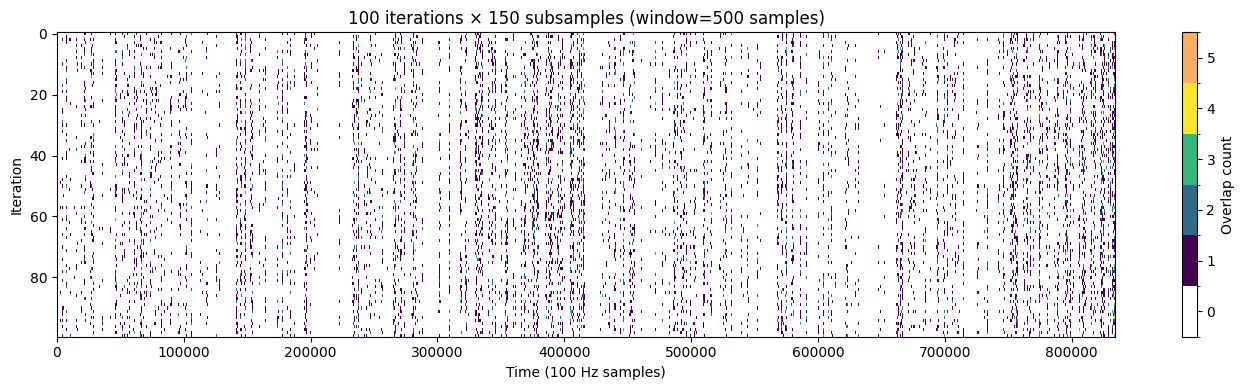

In [39]:
# Heatmap of overlap counts per iteration
fig, ax = plt.subplots(figsize=(14, 4))
im = ax.imshow(canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm)
ax.set_xlabel('Time (100 Hz samples)')
ax.set_ylabel('Iteration')
ax.set_title(f'{iterations} iterations × {n_subsamples} subsamples (window={subsample_tps} samples)')
cbar = fig.colorbar(im, ax=ax, label='Overlap count', boundaries=bounds)
cbar.locator = ticker.FixedLocator(range(0, max_overlap + 1))
cbar.formatter = ticker.FixedFormatter(range(0, max_overlap + 1))
cbar.update_ticks()
plt.tight_layout()
plt.show()


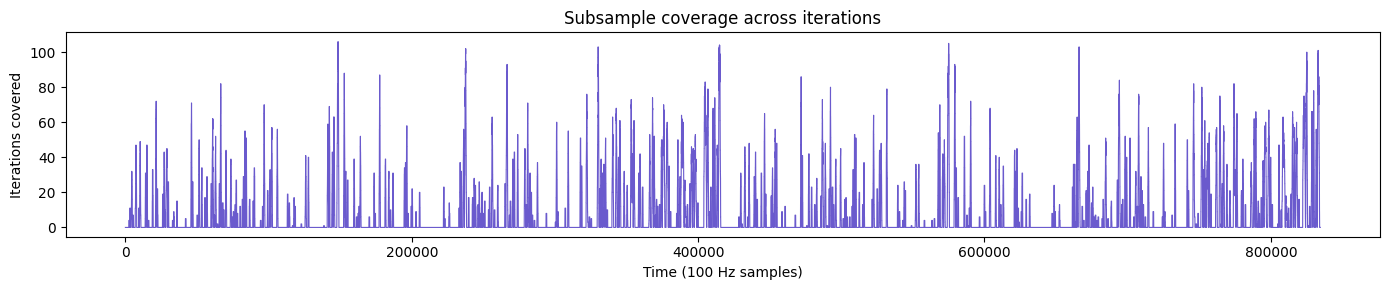

In [40]:
# Global coverage (sum across iterations); toggle `use_plot` for bars vs line
coverage = canvas.sum(axis=0)
fig, ax = plt.subplots(figsize=(14, 3))
times = np.arange(coverage.size)
use_plot = True  # set to False to use a bar plot
if use_plot:
    ax.plot(times, coverage, color='slateblue', linewidth=0.8)
else:
    ax.bar(times, coverage, width=1.0, color='slateblue')
ax.set_xlabel('Time (100 Hz samples)')
ax.set_ylabel('Iterations covered')
ax.set_title('Subsample coverage across iterations')
plt.tight_layout()
plt.show()


/var/folders/hr/kcx2z8ss1tvc10dvl9t52xbh0000gn/T/ipykernel_8107/871846763.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


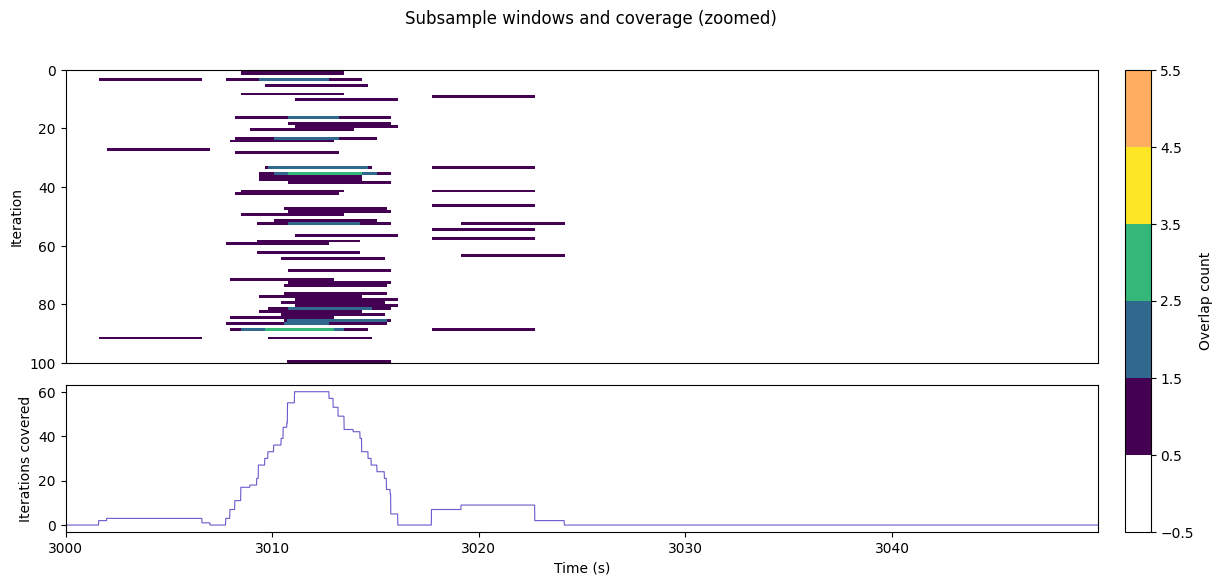

In [41]:
# Combined zoomed view in seconds
window = (300_000, 305_000)  # modify to zoom into another range
start, stop = window
start = max(0, start)
stop = min(canvas.shape[1], stop)
if stop <= start:
    raise ValueError('Invalid window; ensure stop > start within data bounds.')

sub_canvas = canvas[:, start:stop]
sub_coverage = coverage[start:stop]
zoom_samples = np.arange(start, stop)
zoom_seconds = zoom_samples / 100.0

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[40, 1], height_ratios=[2, 1], hspace=0.1, wspace=0.05)
ax_heat = fig.add_subplot(gs[0, 0])
ax_cov = fig.add_subplot(gs[1, 0], sharex=ax_heat)
cax = fig.add_subplot(gs[:, 1])
fig.suptitle('Subsample windows and coverage (zoomed)')

im = ax_heat.imshow(sub_canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm, extent=(zoom_seconds[0], zoom_seconds[-1], iterations, 0))
ax_heat.set_ylabel('Iteration')
ax_heat.set_ylim(iterations, 0)
ax_heat.xaxis.set_visible(False)

fig.colorbar(im, cax=cax, label='Overlap count', boundaries=bounds)

ax_cov.plot(zoom_seconds, sub_coverage, color='slateblue', linewidth=0.8)
ax_cov.set_xlabel('Time (s)')
ax_cov.set_ylabel('Iterations covered')
ax_cov.set_xlim(zoom_seconds[0], zoom_seconds[-1])
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/var/folders/hr/kcx2z8ss1tvc10dvl9t52xbh0000gn/T/ipykernel_8107/3210459940.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


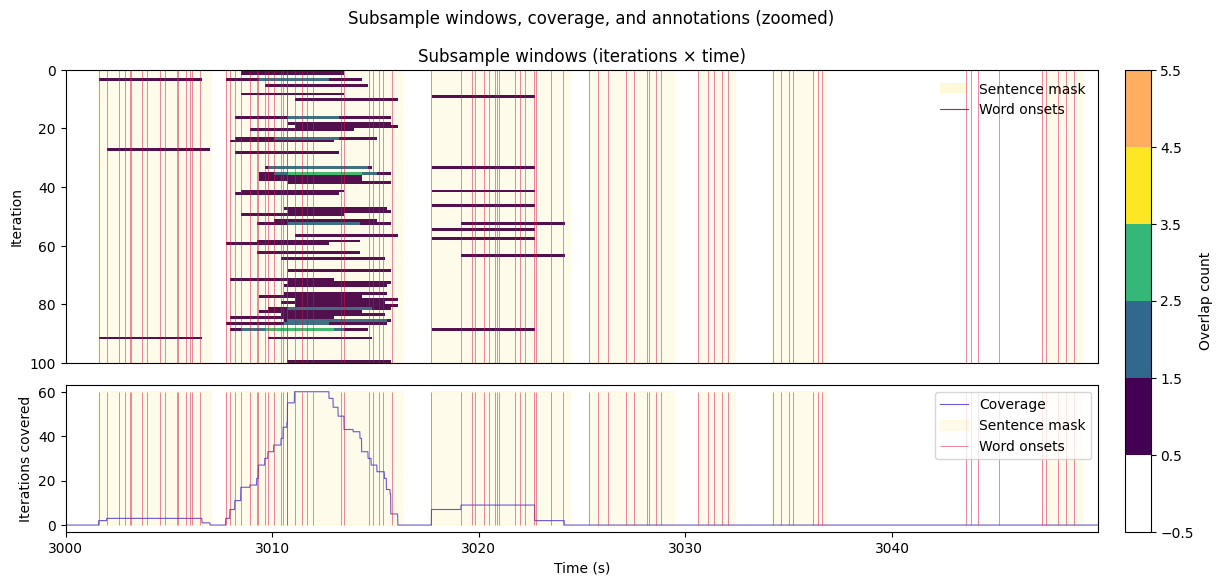

In [42]:
# Combined zoomed view in seconds (with word onset markers)
window = (300_000, 305_000)  # modify to zoom into another range
start, stop = window
start = max(0, start)
stop = min(canvas.shape[1], stop)
if stop <= start:
    raise ValueError('Invalid window; ensure stop > start within data bounds.')

sub_canvas = canvas[:, start:stop]
sub_coverage = coverage[start:stop]
zoom_samples = np.arange(start, stop)
zoom_seconds = zoom_samples / 100.0

# Load onset and mask data for the subject
onset_path = Path('derivatives/preprocessed/sub-01/concatenated/sub-01_concatenated_word_onsets_sec.npy')
subject_onsets = np.load(onset_path)
mask_path = Path('derivatives/preprocessed/sub-01/concatenated/sub-01_concatenated_sentence_mask_100Hz.npy')
sentence_mask = np.load(mask_path).astype(bool)
mask_slice = sentence_mask[start:stop]
onsets_in_window = subject_onsets[(subject_onsets >= zoom_seconds[0]) & (subject_onsets <= zoom_seconds[-1])]

fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, 2, width_ratios=[40, 1], height_ratios=[2, 1], hspace=0.1, wspace=0.05)
ax_heat = fig.add_subplot(gs[0, 0])
ax_cov = fig.add_subplot(gs[1, 0], sharex=ax_heat)
cax = fig.add_subplot(gs[:, 1])
fig.suptitle('Subsample windows, coverage, and annotations (zoomed)')

im = ax_heat.imshow(sub_canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm, extent=(zoom_seconds[0], zoom_seconds[-1], iterations, 0))
ax_heat.set_ylabel('Iteration')
ax_heat.set_title('Subsample windows (iterations × time)')
ax_heat.set_ylim(iterations, 0)
ax_heat.xaxis.set_visible(False)
if mask_slice.any():
    ax_heat.fill_between(zoom_seconds, iterations, 0, where=mask_slice, color='gold', alpha=0.08, step='mid')
for onset in onsets_in_window:
    ax_heat.axvline(onset, color='crimson', linewidth=0.5, alpha=0.7)

heat_handles = []
heat_labels = []
if mask_slice.any():
    heat_handles.append(Patch(facecolor='gold', alpha=0.15))
    heat_labels.append('Sentence mask')
if onsets_in_window.size:
    heat_handles.append(Line2D([0], [0], color='crimson', linewidth=0.8))
    heat_labels.append('Word onsets')
if heat_handles:
    ax_heat.legend(heat_handles, heat_labels, loc='upper right', frameon=False)
fig.colorbar(im, cax=cax, label='Overlap count', boundaries=bounds)

ax_cov.plot(zoom_seconds, sub_coverage, color='slateblue', linewidth=0.8, label='Coverage')
if mask_slice.any():
    ax_cov.fill_between(zoom_seconds, 0, sub_coverage.max(), where=mask_slice, color='gold', alpha=0.08, step='mid', label='Sentence mask')
if onsets_in_window.size:
    ax_cov.vlines(onsets_in_window, ymin=0, ymax=sub_coverage.max(), color='crimson', linewidth=0.6, alpha=0.6, label='Word onsets')
ax_cov.set_xlabel('Time (s)')
ax_cov.set_ylabel('Iterations covered')
ax_cov.set_xlim(zoom_seconds[0], zoom_seconds[-1])
ax_cov.legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/var/folders/hr/kcx2z8ss1tvc10dvl9t52xbh0000gn/T/ipykernel_8107/4206687129.py:95: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


Saved stacked diagnostics to /Volumes/MORWUR/Projects/DAMIANO/SpeDiction/meg-masc/results/subsamples_60238e338e7311d62511b0c3681ef88cb0643ea0.png


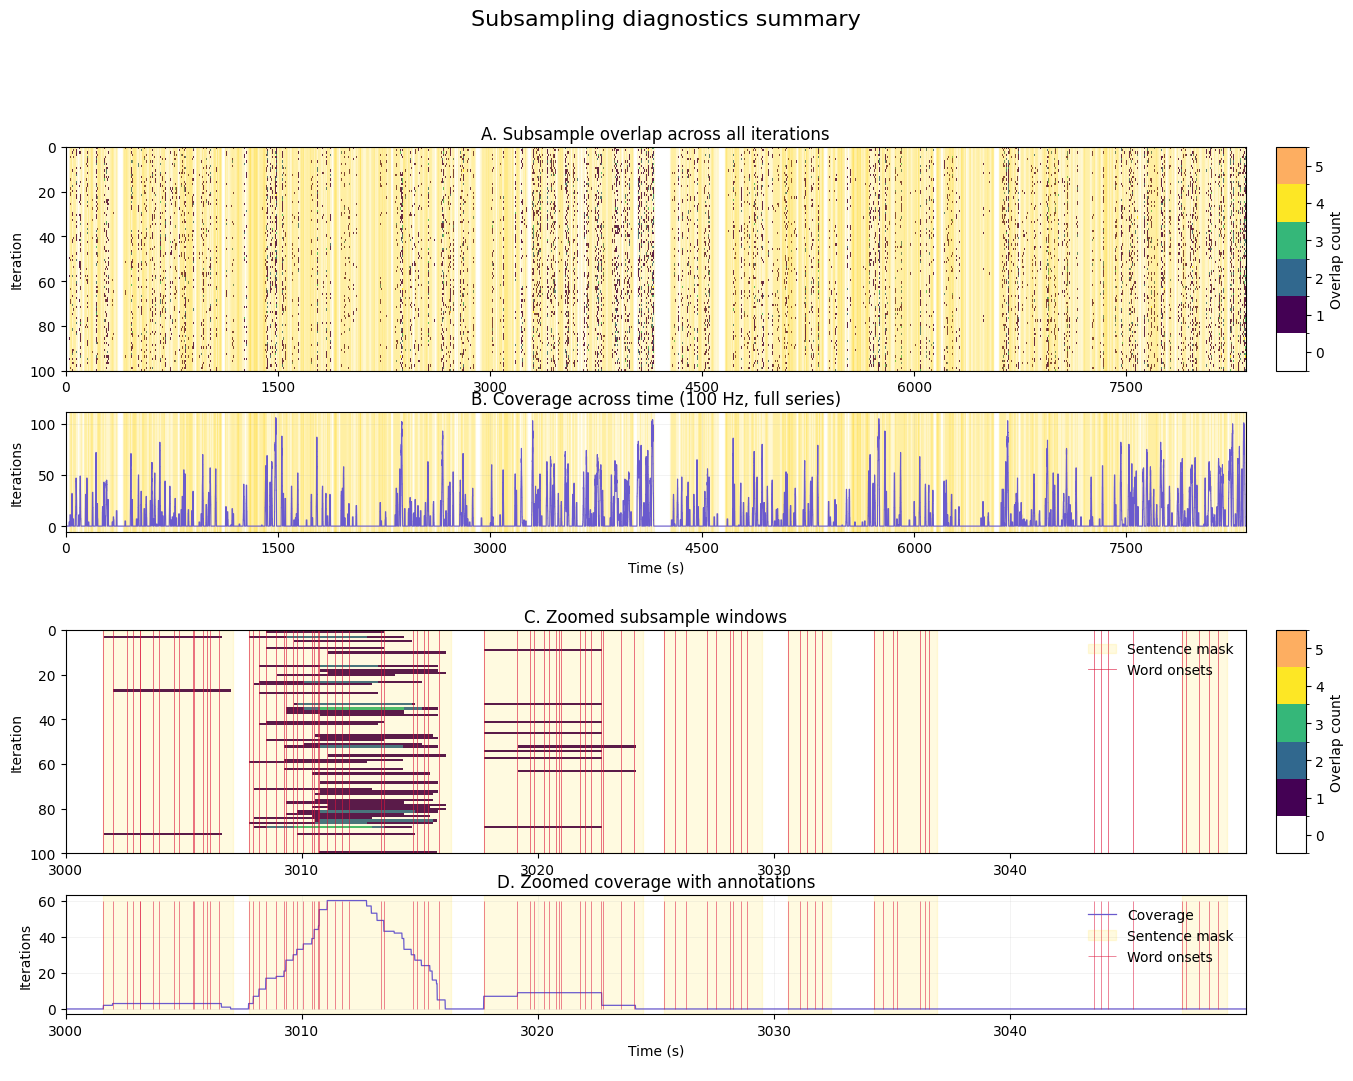

In [43]:
# Export a stacked diagnostic figure
output_path = cache_path.with_suffix('.png')
coverage_seconds = np.arange(coverage.size) / 100.0
total_duration = coverage_seconds[-1] if coverage_seconds.size else 0
dt = 1.0 / 100.0
mask_full = sentence_mask if 'sentence_mask' in globals() else np.zeros_like(coverage, dtype=bool)
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(6, 2, width_ratios=[40, 1], height_ratios=[3, 1.6, 0.2, 3, 1.6, 0.2], hspace=0.35, wspace=0.05)
# Panel A: global heatmap
axA = fig.add_subplot(gs[0, 0])
imA = axA.imshow(canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm, extent=(0, total_duration, iterations, 0))
axA.set_ylabel('Iteration')
axA.set_title('A. Subsample overlap across all iterations')
axA.set_xlim(0, total_duration)
axA.set_xticklabels([])
cbarA = fig.colorbar(imA, cax=fig.add_subplot(gs[0, 1]), label='Overlap count', boundaries=bounds)
cbarA.locator = ticker.FixedLocator(range(0, max_overlap + 1))
cbarA.formatter = ticker.FixedFormatter(range(0, max_overlap + 1))
cbarA.update_ticks()
# Panel B: full coverage
axB = fig.add_subplot(gs[1, 0], sharex=axA)
axB.plot(coverage_seconds, coverage, color='slateblue', linewidth=0.8)
axB.set_ylabel('Iterations')
axB.set_title('B. Coverage across time (100 Hz, full series)')
axB.set_xlim(0, total_duration)
axB.grid(alpha=0.2, linewidth=0.5)
axB.set_xlabel('Time (s)')
axB.xaxis.set_major_locator(ticker.MaxNLocator(6))
axB.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
axB.tick_params(axis='x', labelsize=10)
fig.add_subplot(gs[1, 1]).axis('off')
# Spacer
fig.add_subplot(gs[2, :]).axis('off')
start, stop = window
start = max(0, int(start))
stop = min(canvas.shape[1], int(stop))
if stop <= start:
    raise ValueError('Invalid window; ensure stop > start within data bounds.')
zoom_samples = np.arange(start, stop)
zoom_seconds = zoom_samples / 100.0
sub_canvas = canvas[:, start:stop]
sub_coverage = coverage[start:stop]
mask_slice = mask_full[start:stop]
onsets_in_window = subject_onsets[(subject_onsets >= zoom_seconds[0]) & (subject_onsets <= zoom_seconds[-1])] if 'subject_onsets' in globals() else np.array([])
def shade_mask(ax, times, mask, label=None):
    if not mask.any():
        return
    mask_int = mask.astype(int)
    diffs = np.diff(np.concatenate(([0], mask_int, [0])))
    starts_idx = np.where(diffs == 1)[0]
    ends_idx = np.where(diffs == -1)[0]
    for i, (s_idx, e_idx) in enumerate(zip(starts_idx, ends_idx)):
        start_t = times[s_idx]
        end_idx = min(e_idx, len(times))
        end_t = times[end_idx - 1] + dt
        ax.axvspan(start_t, end_t, color='gold', alpha=0.12, edgecolor=None, label=label if label and i == 0 else None)
shade_mask(axA, coverage_seconds, mask_full)
shade_mask(axB, coverage_seconds, mask_full, label='Sentence mask')

# Panel C
axC = fig.add_subplot(gs[3, 0])
imC = axC.imshow(sub_canvas, aspect='auto', interpolation='nearest', cmap=cmap, norm=norm, extent=(zoom_seconds[0], zoom_seconds[-1], iterations, 0))
axC.set_ylabel('Iteration')
axC.set_title('C. Zoomed subsample windows')
axC.set_ylim(iterations, 0)
shade_mask(axC, zoom_seconds, mask_slice, label='Sentence mask')
for idx_onset, onset in enumerate(onsets_in_window):
    axC.axvline(onset, color='crimson', linewidth=0.6, alpha=0.7, label='Word onsets' if idx_onset == 0 else None)
handles, labels = axC.get_legend_handles_labels()
if handles:
    axC.legend(handles, labels, loc='upper right', frameon=False)
axC.set_xlim(zoom_seconds[0], zoom_seconds[-1])
axC.set_xticklabels([])
cbarC = fig.colorbar(imC, cax=fig.add_subplot(gs[3, 1]), label='Overlap count', boundaries=bounds)
cbarC.locator = ticker.FixedLocator(range(0, max_overlap + 1))
cbarC.formatter = ticker.FixedFormatter(range(0, max_overlap + 1))
cbarC.update_ticks()
# Panel D
axD = fig.add_subplot(gs[4, 0], sharex=axC)
axD.plot(zoom_seconds, sub_coverage, color='slateblue', linewidth=0.9, label='Coverage')
shade_mask(axD, zoom_seconds, mask_slice, label='Sentence mask')
if onsets_in_window.size:
    axD.vlines(onsets_in_window, ymin=0, ymax=sub_coverage.max(), color='crimson', linewidth=0.6, alpha=0.6, label='Word onsets')
axD.set_xlabel('Time (s)')
axD.set_ylabel('Iterations')
axD.set_title('D. Zoomed coverage with annotations')
axD.legend(loc='upper right', frameon=False)
axD.xaxis.set_major_locator(ticker.MaxNLocator(6))
axD.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
axD.tick_params(axis='x', labelsize=10)
axD.grid(alpha=0.2, linewidth=0.5)
fig.add_subplot(gs[4, 1]).axis('off')
fig.add_subplot(gs[5, :]).axis('off')
fig.suptitle('Subsampling diagnostics summary', y=0.995, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig(output_path, dpi=300)
print(f'Saved stacked diagnostics to {output_path.resolve()}')
